In [ ]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mlflow
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# setup mlflow for tracking
mlflow_setup = {
    'EXPERIMENT_NAME' : "Car_Price_Prediction_EDA",
    'TRACKING_URI' : "sqlite:///car_price_prediction_EDA"
}

mlflow.set_tracking_uri(mlflow_setup['TRACKING_URI'])
mlflow.set_experiment(mlflow_setup['EXPERIMENT_NAME'])

<Experiment: artifact_location='file:c:/Users/Maxwe/ML Projects/Car-Price-Prediction-Model/notebooks/mlruns/1', creation_time=1768049801917, experiment_id='1', last_update_time=1768049801917, lifecycle_stage='active', name='Car_Price_Prediction_EDA', tags={}>

# `Step 1: Load Data`

In [ ]:
#read the csv file into the python environment as a pandas dataFrame
def _load_data(data_source: str | Path = "../data/raw/car_details.csv") -> pd.DataFrame:
    """ 
        Loads the data from csv file into the jupyter environment as a pandas dataframe

        Args:
            data_source: str|Path = Path to csv file

        Returns:
            pd.DataFrame containing rows and columns

        Raises:
            FileNotFoundError: If file path is not found
            ValueError: If dataframe is empty
    """
    filepath = Path(data_source)
    if not filepath.exists():
        raise FileNotFoundError(f'File Not Found! Check filepath and try again')
    
    try:
        print(f'Reading Data From CSV File...')
        df = pd.read_csv(data_source) 
        print(f'Data successfully loaded with {len(df)} rows and {len(df.columns)} columns')

        # log dataset and its relevant info in mlflow
        dataset = mlflow.data.from_pandas(
            df, filepath, name='car_price_details',targets="selling_price"
        )

        # log shape of dataset
        mlflow.log_params({
        'n_rows' : len(df),
        'n_columns' : len(df.columns)
        })
        
        return df
    except Exception as e:
        print(f'An error was encountered whiles trying to read data from CSV file : {e}')
        raise


In [ ]:
df = _load_data()

Reading Data From CSV File...
Data successfully loaded with 8128 rows and 13 columns


# `Summary Stats of Numeric Columns`

In [ ]:
def numeric_summary_stats(df: pd.DataFrame, output_dir: str | Path = '../artifacts/results/') -> None:
    """
        Short descriptive summary statistics of numeric columns
        in the dataset and saves the results in a json file for
        persistance and traceability,

        Args: 
            df: pd.DataFrame
            output_file: File path to save json data
        
        Example:
            numeric_summary_stats(df,"results/numeric_summary.json")
    """
    try:
        output_file = output_dir / "numeric_summary.json"
        df.describe().to_json(output_file, indent=4)
        print(f'Numeric descriptive stats saved to {output_file}')

        mlflow.log_artifact(output_file)
    except Exception as e:
        print(f'An error occured whiles trying to save json data : {e}')
        raise

In [ ]:
def categorical_summary_data(df: pd.DataFrame, output_dir: str | Path = '../artifacts/results/') -> None:
    """  
        Short descriptive summary statistcis of categorical columns
        in the dataset and saves the result in a json file for
        persistence and traceability

        Args:
            df: pd.DataFrame
            output_file = File path to save json data
    """
    try:
        output_file = output_dir / "categorical_summary.json"
        df.describe(exclude=[np.number]).to_json(output_file, indent=4)
        print(f'Categorical descriptive stats saved to {output_file}')

        mlflow.log_artifact(output_file)
    except Exception as e:
        print(f'An error occured whiles trying to save json data : {e}')
        raise

In [ ]:
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
cols = [col for col in categorical_cols] #a list comprehension, making a list of categorical columns
print(f'This dataset has {len(cols)} categorical columns - {cols}') #returns the number of categorical columns

This dataset has 6 categorical columns - ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'torque']


In [ ]:
for col in categorical_cols: #loop through categorical columns
    print(f' - {col:<15} | Unique: {df[col].nunique():<3} | Examples:  {df[col].unique()[:3]}') #returns column names, unique values and number of unique values

 - name            | Unique: 2058 | Examples:  ['Volvo XC90 T8 Excellence BSIV' 'Mercedes-Benz S-Class S 350 CDI'
 'Jeep Wrangler 2016-2019 3.6 4X4']
 - fuel            | Unique: 4   | Examples:  ['Petrol' 'Diesel' 'CNG']
 - seller_type     | Unique: 3   | Examples:  ['Individual' 'Dealer' 'Trustmark Dealer']
 - transmission    | Unique: 2   | Examples:  ['Automatic' 'Manual']
 - owner           | Unique: 5   | Examples:  ['First Owner' 'Third Owner' 'Second Owner']
 - torque          | Unique: 441 | Examples:  ['640Nm@ 1740rpm' '490Nm@ 1600rpm' '347Nm@ 4300rpm']


In [ ]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols = [col for col in numerical_cols] # a list comprehension, creating a list of numerical columns
print(f'This dataset has {len(cols)} numerical columns - {cols}') #returns the number of numerical columns

This dataset has 7 numerical columns - ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']


In [ ]:
for cols in numerical_cols: #loops through columns
    print(f'- {cols:<14}   - Min value: {df[cols].min():<12}   - Max value: {df[cols].max()}') #returns column name, minimum value and maximum value

- year             - Min value: 1983           - Max value: 2020
- selling_price    - Min value: 29999          - Max value: 10000000
- km_driven        - Min value: 1              - Max value: 2360457
- mileage          - Min value: 0.0            - Max value: 42.0
- engine           - Min value: 624.0          - Max value: 3604.0
- max_power        - Min value: 0.0            - Max value: 400.0
- seats            - Min value: 2.0            - Max value: 14.0


Definition of Columns
- name - The model name of the car
- fuel - The type of fuel used
- seller type - Who's selling the car
- transmission - The gear system of the car
- owner - Ownership history
- torque - rotational force of the engine
- year - The manufacturing year of the car
- selling_price - The selling price of the car
- km_driven - The number of kilometres the car has been driven
- mileage - the efficiency of the fuel
- engine - engine displacement
- max_power - maximum power output of the engine
- seats - number of seats available in the car

# `DATA QUALITY CHECKS`

In [ ]:
def multiple_data_quality_checks(df: pd.DataFrame) -> None:
    """ 
        Perform multiple data quality checks on the dataframe
        and prints the results to the console

        Args:
            df: pd.DataFrame
    """
    validation = {}
    try:
        print('Performing Data Quality Checks...\n')

        # check if dataframe is empty
        if df.empty:
            raise ValueError('DataFrame is empty!')
        else:
            print('DataFrame is not empty.')
            validation['not_empty'] = True

        # check if dataframe has mutliple rows and columns
        if df.shape[0] < 2 or df.shape[1] < 2:
            raise ValueError('DataFrame must have at least 2 rows and 2 columns!')
        else:
            print('DataFrame has multiple rows and columns.')
            validation['has_multiple_rows_and_columns'] = True

        # check for expected columns
        expected_columns = ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 
                            'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']
        missing_columns = [col for col in expected_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f'Missing expected columns: {missing_columns}')    
        else:
            print('All expected columns are present.')
            validation['expected_columns_present'] = True

        # check for target column
        target_column = 'selling_price'
        if target_column not in df.columns:
            raise ValueError(f'Target column "{target_column}" is missing!')
        else:
            print(f'Target column "{target_column}" is present.')
            validation['target_column_present'] = True

        # check for infinity values
        if np.isinf(df.select_dtypes(include=[np.number])).values.any():
            raise ValueError('DataFrame contains infinity values!')
        else:
            print('No infinity values found in DataFrame.')
            validation['no_infinity_values'] = True

        # check for negative values in numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        negative_value_columns = []
        for col in numerical_cols:
            if (df[col] < 0).any():
                negative_value_columns.append(col)
        if negative_value_columns:
            raise ValueError(f'Numerical columns with negative values: {negative_value_columns}')
        else:
            print('No negative values found in numerical columns.')
            validation['no_negative_values'] = True

        # check for duplicate rows
        duplicate_count = df.duplicated().sum()
        if duplicate_count > 0:
            print(f'Found {duplicate_count} duplicate rows in DataFrame!')
            validation['no_duplicate_rows'] = False
        else:
            print('No duplicate rows found in DataFrame.')
            validation['no_duplicate_rows'] = True
        mlflow.log_param('duplicate_rows', duplicate_count)

        # check for missing values
        missing_value_count = df.isnull().sum().sum()
        if missing_value_count > 0:
            print(f'Found {missing_value_count} missing values in DataFrame!')
            validation['no_missing_values'] = False
        else:
            print('No missing values found in DataFrame.')
            validation['no_missing_values'] = True
        mlflow.log_param('missing_values', missing_value_count)

        # check for range of numerical columns
        for col in numerical_cols:
            col_min = df[col].min()
            col_max = df[col].max()
            print(f'Column "{col}" - Min: {col_min}, Max: {col_max}')
            validation[f'{col}_range'] = (col_min, col_max)
            mlflow.log_param(f'{col}_min', col_min)
            mlflow.log_param(f'{col}_max', col_max)
        print('\nData Quality Checks Completed Successfully.')
        mlflow.log_params(validation)
    except Exception as e:
        print(f'An error occured during data quality checks: {e}')
        raise


In [ ]:
# missing values check
def missing_values_check(df: pd.DataFrame, output_dir: str | Path = '../artifacts/results/') -> pd.DataFrame:
    """
        Check for missing values in the dataframe and return a summary dataframe
        containing columns with missing values, number of missing values and percentage
        of missing values.

        Args:
            df: pd.DataFrame
            output_dir: str|Path = Directory to save the missing values summary

        Returns:
            pd.DataFrame: Summary dataframe with missing values information
    """
    missing_summary = df.isnull().sum()
    if len( missing_summary[missing_summary > 0]) == 0:
        print('No missing values found in the dataset.')
        return pd.DataFrame(columns=['Missing Values', 'Percentage'])
    
    # log parameters to mlflow
    mlflow.log_param('n_missing_columns', len(missing_summary[missing_summary > 0]))
    missing_summary = missing_summary[missing_summary > 0]
    missing_percentage = (missing_summary / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Values': missing_summary,
        'Percentage': missing_percentage
    })
    artifact_path = output_dir / "missing_values_summary.csv"
    missing_df.to_csv(artifact_path)

    mlflow.log_artifact(artifact_path)
    return missing_df

In [ ]:
#checking for duplicated data, keeping the first occurence
def check_duplicates(df: pd.DataFrame) -> int:
    """
        Check for duplicated rows in the dataframe.

        Args:
            df: pd.DataFrame

        Returns:
            int: Number of duplicated rows
    """
    n_duplicates = df.duplicated(keep='first').sum() #returns duplicated rows, keeping only the first occurence
    if n_duplicates > 0:
        print(f'Found {n_duplicates} duplicated rows in the dataset.')
    else:
        print('No duplicated rows found in the dataset.')

    mlflow.log_param('n_duplicated_rows', n_duplicates)
    return n_duplicates


In [ ]:
# handling outliers using IQR method
def handle_outliers_iqr(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
        Handle outliers in a specified column using the IQR method.
        Outliers are capped to the lower and upper bounds.

        Args:
            df: pd.DataFrame
            column: str = Column name to handle outliers
        Returns:
            pd.DataFrame: DataFrame with outliers handled in the specified column
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return {
        'n_outliers': len(outliers),
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

In [ ]:
def outlier_summary(df: pd.DataFrame, output_dir: str | Path = '../artifacts/results/') -> None:
    """
        Generate outlier summary for numerical columns and save to a json file.

        Args:
            df: pd.DataFrame
            output_dir: str|Path = Directory to save the outlier summary
    """
    outlier_info = {}
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    for col in numerical_cols:
        outlier_data = handle_outliers_iqr(df, col)
        outlier_info[col] = outlier_data

    output_file = output_dir / "outlier_summary.json"
    try:
        with open(output_file, 'w') as f:
            import json
            json.dump(outlier_info, f, indent=4)
        print(f'Outlier summary saved to {output_file}')

        mlflow.log_artifact(output_file)
    except Exception as e:
        print(f'An error occurred while trying to save outlier summary: {e}')
        raise

# `VISUALIZATIONS`

In [ ]:
# univariate analysis for numeric columns
def numeric_summary_stats(df: pd.DataFrame, output_dir: str | Path = '../artifacts/plots/', save_plots: bool = True) -> None:
    """
        Generate and save univariate analysis plots for numeric columns.

        Args:
            df: pd.DataFrame
            output_dir: str|Path = Directory to save the plots
            save_plots: bool = Whether to save the plots or display them
    """
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numerical_cols:
        print('No numerical columns found for univariate analysis.')
        return 

    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]

    for idx, col in enumerate(numerical_cols):
            try:
                sns.histplot(
                    data=df,
                    x=col,
                    kde=True,
                    ax=axes[idx],
                    color='purple',
                    alpha=0.7
                )
                axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
                axes[idx].set_ylabel('Frequency')
                axes[idx].grid(True, alpha=0.3)
            except Exception as e:
                print(f'An error occurred while plotting {col}: {e}')
                axes[idx].text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                            ha='center', va='center', transform=axes[idx].transAxes)
        
    # Hide empty subplots
    for idx in range(n_cols, len(axes)):
            axes[idx].set_visible(False)
        
    plt.tight_layout()
        
    if save_plots:
            output_file = output_dir / 'numeric_distributions.png'
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f'Numeric distribution plots saved to {output_file}')
    else:
        plt.show()
    

In [ ]:
# +1: strong positive correlation (as one increases, the other increases)
# -1: strong negative correlation (as one increases, the other decreases)
# 0: no correlation
def plot_correlation_heatmap(df, method: str = 'spearman', plot_dir: str | Path = '../plots/'):
    """  
    This function visualizes the relationship between numerical columns
    through a correlation heatmap

    Args:
        method : whether to use a pearson or spearman method for correlation
        plots_dir : file path to which plot will be saved

    Raises:
        An expection when an error is encountered during plotting and saving the plot
    """
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numerical_cols) < 2:
        print('Not enough numerical columns to plot correlation heatmap.')
        raise ValueError('At least two numerical columns are required.')
    
    if len(df) < 2:
        print('Not enough data to plot correlation heatmap.')
        raise ValueError('At least two rows of data are required.')
    
    try:
        plot_dir = Path(plot_dir)
        plot_dir.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        print(f'An error was encountered while trying to create plot directory : {e}')
        raise

    try:
        print(f'Plotting Correlation Heatmap using {method} method...')
        corr = df[numerical_cols].corr(method=method)
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
        plt.title(f'Correlation Heatmap ({method.capitalize()} Method)', fontsize=16)
        heatmap_path = plot_dir / f'correlation_heatmap_{method}.png'
        plt.savefig(heatmap_path)
        plt.show()
        print(f'Correlation heatmap saved to {heatmap_path}')

        mlflow.log_artifact(heatmap_path)   
        plt.close()
    except Exception as e:
        print(f'An error was encountered while trying to plot correlation heatmap : {e}')
        raise
        

In [ ]:
# box plot visualization
def plot_boxplots(df: pd.DataFrame, output_dir: str | Path = '../artifacts/plots/', save_plots: bool = True) -> None:
    """
        Generate and save box plots for numerical columns.

        Args:
            df: pd.DataFrame
            output_dir: str|Path = Directory to save the plots
            save_plots: bool = Whether to save the plots or display them
    """
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numerical_cols:
        print('No numerical columns found for box plot visualization.')
        return 

    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]

    for idx, col in enumerate(numerical_cols):
            try:
                sns.boxplot(
                    data=df,
                    x=col,
                    ax=axes[idx],
                    color='lightblue'
                )
                axes[idx].set_title(f'Box Plot of {col}', fontweight='bold')
                axes[idx].set_ylabel('Value')
                axes[idx].grid(True, alpha=0.3)
            except Exception as e:
                print(f'An error occurred while plotting box plot for {col}: {e}')
                axes[idx].text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                            ha='center', va='center', transform=axes[idx].transAxes)
        
    # Hide empty subplots
    for idx in range(n_cols, len(axes)):
            axes[idx].set_visible(False)
        
    plt.tight_layout()
        
    if save_plots:
            output_file = output_dir / 'numeric_boxplots.png'
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f'Numeric box plots saved to {output_file}')
    else:
        plt.show()


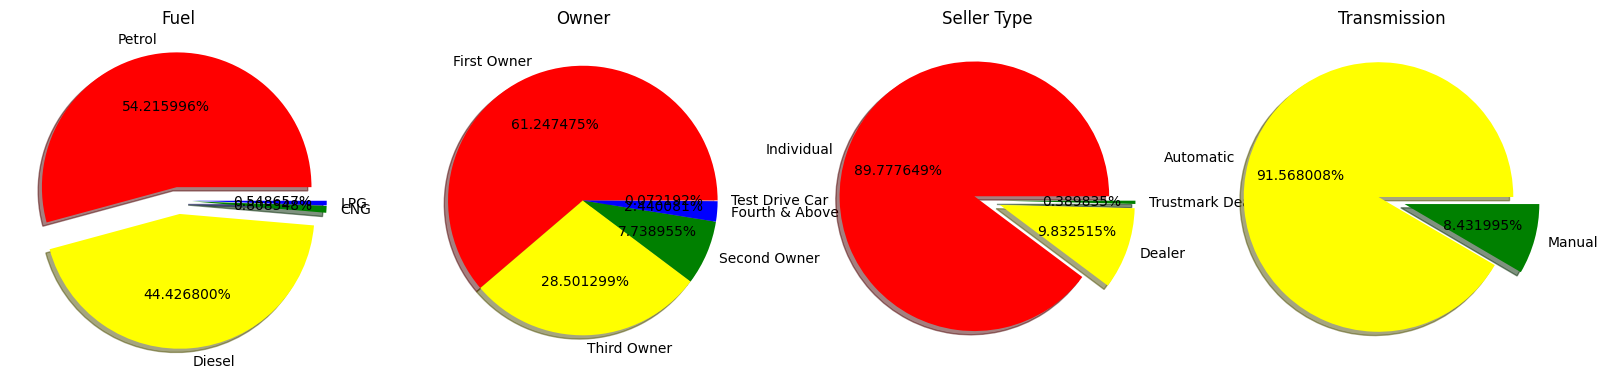

In [ ]:
# plot pie chart for categorical columns
def plot_piechart_categorical(df: pd.DataFrame, column: str, output_dir: str | Path = '../artifacts/plots/', save_plots: bool = True) -> None:
    """
        Generate and save pie chart for a categorical column.

        Args:
            df: pd.DataFrame
            column: str = Categorical column to plot
            output_dir: str|Path = Directory to save the plot
            save_plots: bool = Whether to save the plot or display it
    """
    if column not in df.columns:
        print(f'Column "{column}" not found in DataFrame.')
        return 

    try:
        size = df[column].value_counts()
        labels = df[column].unique()
        colors = plt.cm.Paired.colors[:len(labels)]

        plt.figure(figsize=(8, 6))
        plt.title(f'Pie Chart of {column}', fontsize=16)
        plt.pie(size, labels=labels, colors=colors, autopct='%2f%%', shadow=True, explode=[0.1]*len(labels))
        
        if save_plots:
            output_file = output_dir / f'pie_chart_{column}.png'
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.close()
            print(f'Pie chart for {column} saved to {output_file}')
        else:
            plt.show()
    except Exception as e:
        print(f'An error occurred while plotting pie chart for {column}: {e}')
        raise

# `INFERENCE`

In [ ]:
def confidence_interval(mean: float, std_dev: float, n: int, confidence: float = 0.95) -> tuple:
    """
        Calculate the confidence interval for a given mean, standard deviation, and sample size.

        Args:
            mean: float = Sample mean
            std_dev: float = Sample standard deviation
            n: int = Sample size
            confidence: float = Confidence level (default is 0.95)
        Returns:
            tuple: Lower and upper bounds of the confidence interval
    """
    from scipy import stats
    alpha = 1 - confidence
    t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
    margin_of_error = t_critical * (std_dev / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return (lower_bound, upper_bound)

def plot_confidence_intervals(df: pd.DataFrame, column: str, output_dir: str | Path = '../artifacts/plots/', save_plots: bool = True) -> None:
    """
        Generate and save confidence interval plot for a numerical column.

        Args:
            df: pd.DataFrame
            column: str = Numerical column to plot
            output_dir: str|Path = Directory to save the plot
            save_plots: bool = Whether to save the plot or display it
    """
    if column not in df.columns:
        print(f'Column "{column}" not found in DataFrame.')
        return 

    try:
        mean = df[column].mean()
        std_dev = df[column].std()
        n = len(df[column])
        lower_bound, upper_bound = confidence_interval(mean, std_dev, n)

        plt.figure(figsize=(8, 6))
        plt.errorbar(x=[0], y=[mean], yerr=[[mean - lower_bound], [upper_bound - mean]], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
        plt.xlim(-1, 1)
        plt.title(f'Confidence Interval for {column}', fontsize=16)
        plt.ylabel(column)
        plt.xticks([])

        if save_plots:
            output_file = output_dir / f'confidence_interval_{column}.png'
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.close()
            print(f'Confidence interval plot for {column} saved to {output_file}')
        else:
            plt.show()
    except Exception as e:
        print(f'An error occurred while plotting confidence interval for {column}: {e}')
        raise


In [ ]:

def main():
    # Perform data quality checks
    multiple_data_quality_checks(df)

    # Generate numeric summary statistics
    numeric_summary_stats(df)

    # Generate categorical summary statistics
    categorical_summary_data(df)

    # Check for missing values
    missing_values_df = missing_values_check(df)
    print(missing_values_df)

    # Check for duplicated rows
    n_duplicates = check_duplicates(df)
    print(f'Number of duplicated rows: {n_duplicates}')

    # Generate outlier summary
    outlier_summary(df)

    # Plot numeric distributions
    numeric_summary_stats(df)

    # Plot correlation heatmap
    plot_correlation_heatmap(df, method='spearman')

    # Plot box plots for numerical columns
    plot_boxplots(df)

    # Plot pie charts for categorical columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    for col in categorical_cols:
        plot_piechart_categorical(df, col)

    # Plot confidence intervals for numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numerical_cols:
        plot_confidence_intervals(df, col)
if __name__ == "__main__":
    main()